In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
#from sklearnex import patch_sklearn # no funciona bien con TSNE
#patch_sklearn()
#import optuna
from sklearn.ensemble import IsolationForest
#from sklearn.model_selection import KFold
import itertools
import pickle
from tensorflow_helper import visualize_images_tf_way, multiclass_pred_new_image_plotly, load_and_prep_image
from sklearn.preprocessing import LabelEncoder
import tensorflow_datasets as tfds

In [1]:
import gdown
import tensorflow as tf

In [7]:
def download_model_from_google_drive(url, output_name):
    gdown.download(url, output_name, quiet=False)
    # Now load the model from the file
    model = tf.keras.models.load_model(output_name)
    return model

In [8]:
file_id = "1jJIhQRTHUh5cKF9SZVyNT0FyGAVnQ-mf"
url = f'https://drive.google.com/uc?export=download&id={file_id}'
model = download_model_from_google_drive(url, "model.h5")

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1jJIhQRTHUh5cKF9SZVyNT0FyGAVnQ-mf
From (redirected): https://drive.google.com/uc?export=download&id=1jJIhQRTHUh5cKF9SZVyNT0FyGAVnQ-mf&confirm=t&uuid=2d04a973-f86e-41d1-978d-cac9afd24757
To: C:\Users\56976\Desktop\GitHub\Food_vision\model.h5
100%|██████████| 156M/156M [00:02<00:00, 56.9MB/s] 

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Loading data

In [52]:
train_dir = "C:/Users/56976/Desktop/courses&datasets/main_datasets/food_vis_10_classes/train/"
test_dir = "C:/Users/56976/Desktop/courses&datasets/main_datasets/food_vis_10_classes/test/"

tf.random.set_seed(42)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=None, #0.2
    seed=42,
    subset=None, #"training"
    image_size=(224, 224),  #Height, width
    batch_size=32,
    shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=42,
    validation_split=None, #0.2
    subset=None,   #validation"
    image_size=(224, 224),
    batch_size=32,
    shuffle=True)

class_names = train_ds.class_names

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [53]:
# (train_ds, val_ds), ds_info = tfds.load(name="food101", data_dir="../datasets/",
#                                         split=["train","validation"],
#                                         shuffle_files=False,
#                                         as_supervised=True, # data gets returned as tuple format (data,label)
#                                         with_info=True,
#                                         download=False)

In [54]:
# mnist_builder = tfds.builder('food101')  # this gives me directory of saved datasets
# print(mnist_builder.data_dir)

In [55]:
# class_names = ds_info.features["label"].names
# class_names[:10]

In [56]:
# Make a function for preprocessing images
# def preprocess_img(image, label, img_shape=224):
#     """
#     Converts image datatype from 'uint8' -> 'float32' and reshapes image to
#     [img_shape, img_shape, color_channels]
#     """
#     image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
#     return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [5]:
# # Map preprocessing function to training data (and paralellize)
# train_ds = train_ds.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# # Shuffle train_data and turn it into batches and prefetch it (load it faster)
# train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)#.cache()
#
# # Map prepreprocessing function to test data
# val_ds = val_ds.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# # Turn test data into batches (don't need to shuffle)
# val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)#.cache() only usable if dataset is small to speed up

In [57]:
label_encoder = LabelEncoder().fit(class_names)

In [58]:
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

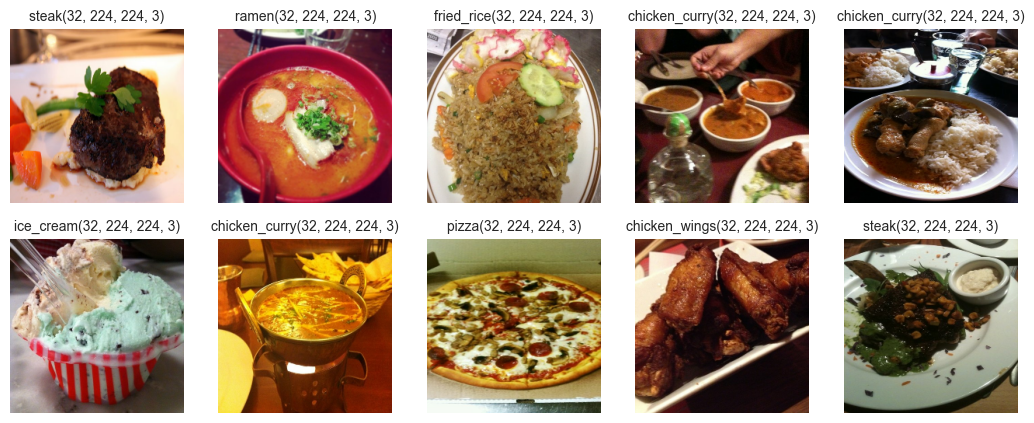

In [13]:
visualize_images_tf_way(train_ds, class_names=class_names, tfds=False)

## Model effnetv2b3

In [16]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomRotation(0.2, seed=42),
#     tf.keras.layers.RandomZoom(0.2, seed=42),
#     tf.keras.layers.RandomHeight(0.2, seed=42),
#     tf.keras.layers.RandomHeight(0.2, seed=42),
#     #tf.keras.layers.RandomBrightness(factor=[-0.1,0.1]),
#     #tf.keras.layers.RandomContrast(0.2),
#     #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
#     tf.keras.layers.RandomFlip("horizontal", seed=42),
#     #tf.keras.layers.Rescaling(1./255)
# ],
#     name="data_augmentation")

In [22]:
checkpoint_path = "weights_checkpoints/checkpoint_food_vision/CP"

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True
                                                         ,verbose=1, save_freq="epoch",monitor="val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0, patience=2, restore_best_weights=True)

In [15]:
from tensorflow.keras import mixed_precision
#
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 with Max-Q Design, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 with Max-Q Design, compute capability 7.5


> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).

In [16]:
# Setup the input shape and base model. freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False, include_preprocessing=True)
base_model.trainable = False


inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer") #Inputs
#x = data_augmentation(inputs)               # Add data augmentation
x = base_model(inputs,training=False)          #Give base_model the inputs after augmentation, makes sure batch norm layers doesnt change
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer_2d", dtype="float32")(x) # Pool output features of the base model.
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer", dtype="float32")(x)  #Dense layer as output

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Model(inputs,outputs)  #Make the model

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                 metrics=["accuracy"])

in_epoch = 4

hist = model.fit(train_ds, steps_per_epoch=len(train_ds), validation_data=val_ds,
                                       validation_steps=(len(val_ds)),
                                       epochs=in_epoch, verbose=1, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/4
235/235 [==============================] - ETA: 0s - loss: 0.7373 - accuracy: 0.7868
Epoch 1: val_accuracy improved from -inf to 0.88640, saving model to weights_checkpoints/checkpoint_food_vision\CP
235/235 [==============================] - 30s 83ms/step - loss: 0.7373 - accuracy: 0.7868 - val_loss: 0.3692 - val_accuracy: 0.8864
Epoch 2/4
235/235 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.8711
Epoch 2: val_accuracy improved from 0.88640 to 0.89640, saving model to weights_checkpoints/checkpoint_food_vision\CP
235/235 [==============================] - 17s 70ms/step - loss: 0.4146 - accuracy: 0.8711 - val_loss: 0.3067 - val_accuracy: 0.8964
Epoch 3/4
234/235 [============================>.] - ETA: 0s - loss: 0.3481 - accuracy: 0.8929
Epoch 3: val_accuracy improved from 0.89640 to 0.90400, saving model to weights_checkpoints/checkpoint_food_vision\CP
235/235 [==============================] - 17s 72ms/step - loss: 0.3485 - accuracy: 0.8925 - val_l

## Finetune effnetv2b3

In [28]:
# Seeing model variables, and seeing if they are trainable or not
print(len(model.layers[1].layers))
for i, layer in enumerate(model.layers[1].layers):
    #print(i, layer.name, layer.trainable)
    pass

409


In [41]:
# to begin fine-tuning, let's start by setting the last 18 layers of our base_model.trainable = True
base_model.trainable = True

#Freeze all layers except for the last 18
#for layer in base_model.layers[:-400]:
    #layer.trainable = False


# Recompile (we have to recompile our models everytime we make a change)
# I should make a very low learning rate when i start fine-tuning, thumb rule. lower lr by 10x.
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                metrics=["accuracy"])

In [42]:
# checkpoint_path = "weights_checkpoints/checkpoint_food_vision/CP"
#
# # Create a ModelCheckpoint callback that saves the model's weights only.
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True
#                                                          ,verbose=1, save_freq="epoch")

In [43]:
in_epoch = hist.epoch[-1] # start training from previous last epoch.
fine_tune_epochs = in_epoch + 5

hist = model.fit(train_ds, steps_per_epoch=len(train_ds), validation_data=val_ds,
                                                 validation_steps=(len(val_ds)),
                                                 epochs=fine_tune_epochs, initial_epoch=in_epoch,  verbose=1,
                                                 callbacks=[checkpoint_callback, early_stopping])

Epoch 19/23
235/235 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9935
Epoch 19: val_accuracy did not improve from 0.93360
235/235 [==============================] - 61s 182ms/step - loss: 0.0220 - accuracy: 0.9935 - val_loss: 0.3291 - val_accuracy: 0.9252
Epoch 20/23
235/235 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9996
Epoch 20: val_accuracy improved from 0.93360 to 0.93800, saving model to weights_checkpoints/checkpoint_food_vision\CP
235/235 [==============================] - 41s 176ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.2833 - val_accuracy: 0.9380
Epoch 21/23
235/235 [==============================] - ETA: 0s - loss: 2.5270e-04 - accuracy: 1.0000
Epoch 21: val_accuracy improved from 0.93800 to 0.94280, saving model to weights_checkpoints/checkpoint_food_vision\CP
235/235 [==============================] - 42s 177ms/step - loss: 2.5270e-04 - accuracy: 1.0000 - val_loss: 0.2832 - val_accuracy: 0.9428
Epoch 22/

In [44]:
model.load_weights("weights_checkpoints/checkpoint_food_vision/CP")

In [45]:
model.save("food_vis_model.h5")

In [59]:
model = tf.keras.models.load_model("food_vis_model.h5")

In [7]:
multiclass_pred_new_image_plotly(model, "pizza.jpg", train_ds.class_names)

1/1 [==============================] - 7s 7s/step


## Creating embedded model

In [60]:
def create_embedding_model(model):
    embedding_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-2].output)
    return embedding_model

embedding_model = create_embedding_model(model)

In [61]:
embedding_model.save("embedding_model.h5")

In [146]:
features = []

for images, labels in train_ds:
    batch_features = embedding_model.predict(images, verbose=0)
    features.append(batch_features)

features = np.vstack(features)

In [147]:
# Save the features to a file
np.save('features.npy', features)

In [81]:
for target_label in class_names[0:2]:
    print(target_label)

chicken_curry
chicken_wings


In [83]:
class_features = {}

for target_label in class_names:
    encoded_target_label = label_encoder.transform([target_label])[0]
    features = []

    for images, labels in train_ds:
        # Create a boolean mask for target_label in the current batch
        target_mask = tf.equal(labels, encoded_target_label)

        # Extract the images corresponding to target_label using the boolean mask
        target_images = tf.boolean_mask(images, target_mask)

        # If target_label is found in the batch, compute features for target images
        if target_images.shape[0] > 0:
            batch_features = embedding_model.predict(target_images, verbose=0)
            features.append(batch_features)

    features = np.vstack(features)
    class_features[target_label] = features


In [106]:
batch_features

array([[ 2.1032224 ,  0.6509178 ,  0.03959874, ..., -0.1579993 ,
        -0.10586081,  0.04423928],
       [ 1.2735465 , -0.02811794, -0.04464296, ...,  0.00973121,
         0.16303456,  0.34604442],
       [ 1.16459   , -0.10963292, -0.07492829, ..., -0.14478037,
        -0.13680173,  1.2284402 ],
       ...,
       [ 2.1314435 ,  0.38260198, -0.14436466, ..., -0.13399334,
        -0.16720518, -0.0586593 ],
       [ 2.0130563 ,  0.4223007 ,  0.23089397, ...,  0.1529133 ,
         0.05459778,  0.03507665],
       [ 1.1608332 ,  0.11087316,  0.87627673, ...,  0.06544907,
         0.42216578,  0.6000559 ]], dtype=float32)

In [85]:
with open("features.pkl", "wb") as f:
    pickle.dump(class_features, f)

## Isolation Forest

In [23]:
from sklearn.ensemble import IsolationForest

outlier_detector = IsolationForest(contamination="auto", n_estimators=200)
outlier_detector.fit(features)

IsolationForest(n_estimators=200)

In [ ]:
def stability_score(y_pred):
    return np.mean([np.mean(y1 == y2) for y1, y2 in itertools.combinations(y_pred, 2)])

def objective(trial, X):
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    max_samples = trial.suggest_categorical("max_samples", ['auto', 100, 200, 300, 500, 1000])
    contamination = trial.suggest_categorical("contamination",  ['auto', 0.01, 0.1, 0.2,0.3, 0.05,0.4,0.5])

    kf = KFold(n_splits=3)  # Change the number of splits if needed
    y_pred = []

    for train_index, _ in kf.split(X):
        X_train = X[train_index]

        isolation_forest = IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination, random_state=42)
        isolation_forest.fit(X_train)

        preds = isolation_forest.predict(X_train)
        y_pred.append(preds)

    stability = stability_score(y_pred)

    return stability  # We want to maximize

study = optuna.create_study(direction="maximize")
func = lambda trial: objective(trial, features )
study.optimize(func, n_trials=30)

best_params = study.best_params
print("Best hyperparameters found:", best_params)

In [10]:
outlier_detector = IsolationForest(**best_params).fit(features)

In [11]:
with open('outlier_detector.pkl', 'wb') as file:
    pickle.dump(outlier_detector, file)

In [12]:
from PIL import Image

def load_and_prepare_image(img, rescale=False):
    img = Image.open(img).convert('RGB')
    img = img.resize((224, 224))  # Resize the image to required dimensions
    if rescale:
        img = np.array(img) / 255.0  # Normalize the pixel values
    return np.expand_dims(img, axis=0)  # Add batch dimension


im1 = load_and_prepare_image("pizza.jpg", rescale=True)

new_feature_vector = embedding_model.predict(im1)

is_outlier = outlier_detector.predict(new_feature_vector.reshape(1, -1))

1/1 [==============================] - 0s 31ms/step


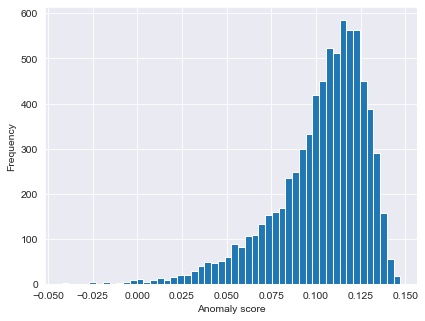

In [28]:
anomaly_scores = outlier_detector.decision_function(features)
plt.hist(anomaly_scores, bins=50)
plt.xlabel("Anomaly score")
plt.ylabel("Frequency")
plt.show()

# Set a threshold based on the distribution of the scores, e.g., the 5th percentile
thresholdd = np.percentile(anomaly_scores, 10)

In [25]:
im1 = load_and_prepare_image("pizza.jpg", rescale=False)

new_feature_vector = embedding_model.predict(im1)

anomaly_score = outlier_detector.decision_function(new_feature_vector.reshape(1, -1))

1/1 [==============================] - 2s 2s/step


##  Mahalanobis Distance-based Confidence Score (MCD) for OOD detection using TensorFlow and Keras

The Mahalanobis Distance-based Confidence Score (MCD) is a method for out-of-distribution (OOD) detection based on the Mahalanobis distance metric. The Mahalanobis distance is a measure of the distance between a point and a distribution, which takes into account the correlations among variables. This method can be used to detect samples that deviate significantly from the distribution of known, in-distribution data.

Here is a detailed explanation of the MCD method for OOD detection:

Feature extraction: Train a deep learning model on your in-distribution dataset for image classification. Once the model is trained, remove the final classification layer to obtain a feature extractor. This feature extractor will produce feature vectors for the input images.

Compute mean and covariance: Use the feature extractor to compute feature vectors for the in-distribution dataset. Calculate the mean and covariance matrix of these feature vectors. The mean represents the central tendency of the in-distribution data in the feature space, while the covariance matrix captures the spread and correlations among features.

Compute inverse covariance: Calculate the inverse of the covariance matrix. The inverse covariance matrix is used to normalize the Mahalanobis distance calculation by considering the correlations among features.

Compute Mahalanobis distance: For a given input image, extract its feature vector using the feature extractor. Then, compute the Mahalanobis distance between this feature vector and the mean of the in-distribution feature vectors using the inverse covariance matrix. The Mahalanobis distance is defined as:

D(x) = √((x - μ)ᵀ · Σ⁻¹ · (x - μ))

where x is the feature vector of the input image, μ is the mean of the in-distribution feature vectors, Σ⁻¹ is the inverse covariance matrix, and D(x) is the Mahalanobis distance.

Set a threshold: Determine a threshold value for the Mahalanobis distance based on the desired trade-off between false positives (in-distribution samples classified as OOD) and false negatives (OOD samples classified as in-distribution). You can use a validation set and analyze the distribution of Mahalanobis distances for both in-distribution and known out-of-distribution samples to select an appropriate threshold.

Classify OOD samples: For a new input image, compute its Mahalanobis distance using the steps mentioned above. If the distance is greater than the predetermined threshold, classify the image as an out-of-distribution sample. Otherwise, classify it as an in-distribution sample.

The MCD method for OOD detection is effective because it considers the distribution of the in-distribution data in the feature space and takes into account the correlations among features. By measuring the distance of an input image's feature vector from the mean of the in-distribution data, the method can effectively detect samples that deviate from the expected distribution. However, like any other OOD detection method, the MCD method may require tuning and experimentation to achieve the best results for a specific application.

In [99]:
feats = []
for values in class_features.values():
    feats.append(values)

feats = np.vstack(feats)





In [140]:
from scipy.spatial import distance_matrix

#features = feats
features = class_features["pizza"]

mean = np.mean(features, axis=0)
print(mean)
print("\n")
covariance = np.cov(features, rowvar=False)
print(covariance)
inv_covariance = np.linalg.inv(covariance + 1e-2 * np.eye(covariance.shape[0]))
print(inv_covariance)

[ 1.9201317   0.18540706 -0.01612005 ... -0.04380447 -0.08403713
  0.38352603]


[[ 0.65138778  0.01737374  0.01521768 ...  0.01289041 -0.00950483
   0.04165792]
 [ 0.01737374  0.11743491  0.016438   ...  0.01309743  0.01143418
  -0.01201928]
 [ 0.01521768  0.016438    0.05389147 ...  0.0158373   0.01354878
   0.01337687]
 ...
 [ 0.01289041  0.01309743  0.0158373  ...  0.04316156  0.00983855
   0.01927136]
 [-0.00950483  0.01143418  0.01354878 ...  0.00983855  0.02500016
   0.01548   ]
 [ 0.04165792 -0.01201928  0.01337687 ...  0.01927136  0.01548
   0.22523762]]
[[ 3.27977684e+01 -4.59905095e-02  2.71791340e-01 ... -3.02769689e-01
   3.43920581e-01  4.96014465e-01]
 [-4.59905095e-02  6.47292596e+01  4.30795719e-01 ... -1.48730225e-04
  -9.30047438e-01 -6.06652849e-01]
 [ 2.71791340e-01  4.30795719e-01  7.83391818e+01 ... -6.66564900e-01
  -1.02315491e-01 -1.55807593e-01]
 ...
 [-3.02769689e-01 -1.48730225e-04 -6.66564900e-01 ...  7.96565276e+01
  -6.21695475e-01 -6.82351020e-01]
 [ 3.

In [141]:
inv_covariance

array([[ 3.27977684e+01, -4.59905095e-02,  2.71791340e-01, ...,
        -3.02769689e-01,  3.43920581e-01,  4.96014465e-01],
       [-4.59905095e-02,  6.47292596e+01,  4.30795719e-01, ...,
        -1.48730225e-04, -9.30047438e-01, -6.06652849e-01],
       [ 2.71791340e-01,  4.30795719e-01,  7.83391818e+01, ...,
        -6.66564900e-01, -1.02315491e-01, -1.55807593e-01],
       ...,
       [-3.02769689e-01, -1.48730225e-04, -6.66564900e-01, ...,
         7.96565276e+01, -6.21695475e-01, -6.82351020e-01],
       [ 3.43920581e-01, -9.30047438e-01, -1.02315491e-01, ...,
        -6.21695475e-01,  8.61613100e+01, -6.09264114e-01],
       [ 4.96014465e-01, -6.06652849e-01, -1.55807593e-01, ...,
        -6.82351020e-01, -6.09264114e-01,  4.82276600e+01]])

In [142]:
img = load_and_prep_image("pizza.jpg")

In [143]:
test_feature_vector = embedding_model.predict(np.expand_dims(img, axis=0))

1/1 [==============================] - 0s 28ms/step


In [144]:
mahalanobis_distance = np.sqrt(np.dot(np.dot((test_feature_vector - mean), inv_covariance), (test_feature_vector - mean).T).diagonal())
# Set a threshold to classify as OOD or in-distribution
threshold = 60  # Adjust this value based on your application
print(mahalanobis_distance)
if mahalanobis_distance > threshold:
    print("Maholanobis rechaza esta imagen al ser muy distinta a las imagenes con las que fue entranado el modelo.")
else:
    print("The test image belongs to one of the supported classes.")

[31.36133899]
The test image belongs to one of the supported classes.


In [145]:
mahalanobis_distance[0]

31.3613389947525

In [133]:
# Save the features to a file
np.save('features.npy', features)